<h3>CMM Sample Data Crustal Thickness Analysis II - Method, Results, and Interpretation</h3>

__Notebook Initial Creation:__ 1/23/2017 <br>
__Author:__ pjparis

__This notebook continues the thread developed in notebook: CMM Sample Data (20k pnts) Crustal Thickness Analysis__

<h4>Initial Data Load:</h4>

In [7]:
fpath='/Users/paulp/GoogleDrive/projects/ContinentalMarginMapping/data/GCS_EDA_sampling/'
file='CMM_20krandompnts.csv'

df = pd.read_csv(fpath+file, names=['ID','CrustThk','Elevation','Magnetic','Gravity','gForms','Lon','Lat'], skiprows=1).dropna()

<h4>Data Preprocessing:</h4>

In [10]:
# import the Matplotlib plotting handlers:
from matplotlib import pyplot as plt

%matplotlib inline

# Render crustal thickness as positive values. Prior were all measured as
# distances from the sea bed to base of crust (Moho) so < 0:
df.CrustThk = df.CrustThk* -1

# build the arrays needed for the Natural Breaks from the df:
X = df.ix[:,1:5]                # extract the continuous numeric fields in df
y = np.array(df.ix[:,5] )       # extract the geomorphon type classifier field only


<h4>The Fisher-Jenks Natural Breaks Optimization Routines - Part A: the Callable Functions</h4>

In [4]:
import random
from pysal.esda.mapclassify import Natural_Breaks as nb
import time

def ComputeNaturalBreaks(pc_array, klasses):
    '''
    partitions data into classes using PySAL pysal.esda.mapclassify, Natural_Breaks algorithm. 
    input: array of values to classify
    returns: upper bounds for classes
    '''
    breaks=nb(pc_array, k=klasses, initial=20)
    return(breaks)


def goodness_of_variance_fit(array, classes):
    # get the break points
    #classes = jenks(array, classes)

    # do the actual classification - assign values based on class breaks
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf


def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

# ##
# ## Call ComputeClusterBndys with data to generate class break cluster boundarys...  <--------- call this guy
# ##
def ComputeClusterBndys(data_array, num_classes, gvf_threshold):
    start_time = time.time()

    pc_array = np.array(data_array)    # extract the crustal thickness column from the df
    breaksList=[]

    klasses=num_classes
    gvf = 0.0
    gvf_acceptance=gvf_threshold
    
    # compute F-J natural breaks and goodness of fit:
    while(gvf < gvf_acceptance):
        print('Trying', klasses, 'class breaks...')
        # classify data using PySAL Natural Breaks Lib.
        breaks=ComputeNaturalBreaks(pc_array, klasses)

        # compute goodness of variance fit
        gvf = goodness_of_variance_fit(pc_array, breaks.bins)   #(data, nclasses)
        klasses+=1
    
    breaksList.append(breaks.bins) 
    
    return(breaksList)

print('N-B Functions Loaded...')

N-B Functions Loaded...


<h4>Continued Exploratory Analysis of Crustal Thickness:</h4>

1. Partition the full sample data set into observations emergent (elevation >= 0) and submergent (elevation < 0)
2. Plot the overall crustal thickness data vs. elevation, then...
3. Plot the emergent and submergent crustal thickness data vs. elevation
4. Cluster (using Natural Breaks and/or another clustering tool) the emergent and submergent elevations and thicknesses
5. ...

In [14]:
# extract all records from the df where elevation < 0:
df_wet = df.query('Elevation < 0.0')

# extract all records from the df where elevation >= 0:
df_dry = df.query('Elevation >= 0.0')

__Crustal thickness vs. gravity and elevation (all sample observations)__

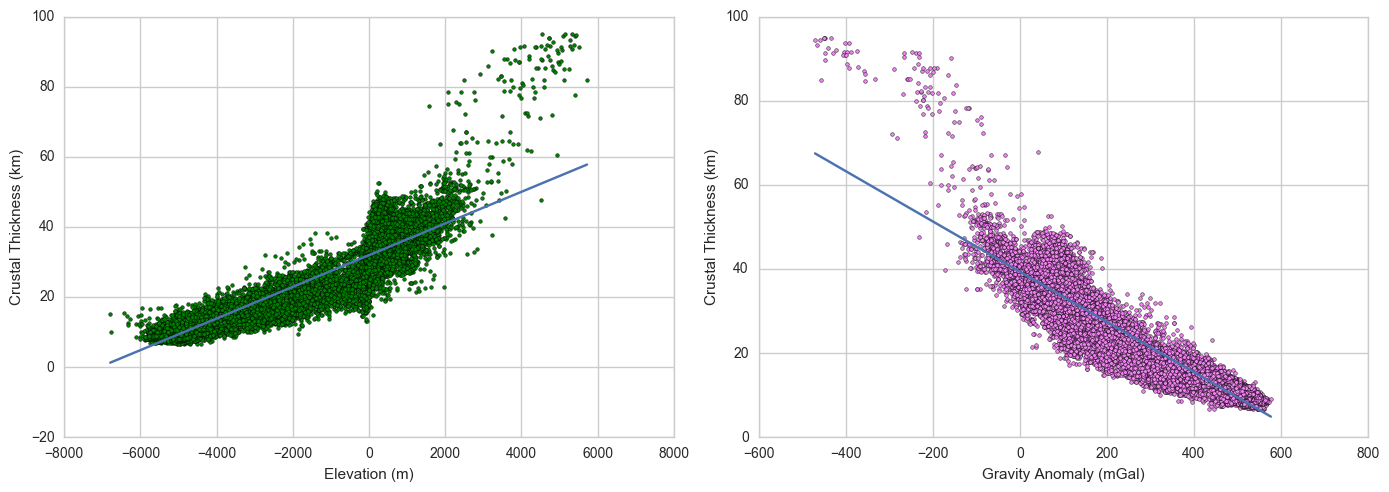

In [12]:
fig1 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax1 = fig1.add_subplot(1,2,1)
    ax1.scatter(df.Elevation, df.CrustThk, s=7, c='green', label='')
    ax1.set_xlabel('Elevation (m)')
    ax1.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax1.plot(np.unique(df.Elevation), np.poly1d(np.polyfit(df.Elevation, df.CrustThk, 1))(np.unique(df.Elevation)))
    
    ax1 = fig1.add_subplot(1,2,2)
    ax1.scatter(df.Gravity, df.CrustThk, s=7, c='violet', label='')
    ax1.set_xlabel('Gravity Anomaly (mGal)')
    ax1.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax1.plot(np.unique(df.Gravity), np.poly1d(np.polyfit(df.Gravity, df.CrustThk, 1))(np.unique(df.Gravity)))
    
    plt.tight_layout()
    plt.show()

Note that both elevation and gravity appear to respond in a concerted manner to changes in crustal thickness. For elevation, thicknesses are least for the least of elevations (in the deep ocean basins) and trends progressively thicker with the approach to sea level. Above sea level thickness continue to increase, but the rate changes--increasing notably with increasing elevation. Based on this result, we could reasonably fit a pair of straight lines, one for thickness values below sea level, and another above, to describe the relationship between the two variables. 

A similar, but inverse outcome is seen between crustal thickness and gravity. The thinnest crust are associated with the highest positive gravity anomalies. As the crust thickens the gravity anomaly magnitudes diminish, and in linear fashion, until a thickness of around 20 - 25 km, where, like with elevation, the trend (rate or slope) increases notably up to about 80 - 85 km, where it then begins to level off as the thickest sections are encountered. Gravity anomalies mark a 0 crossing at a thickness of about 40 km. 

Let's look at the data parsed into emergent and submergent parts:

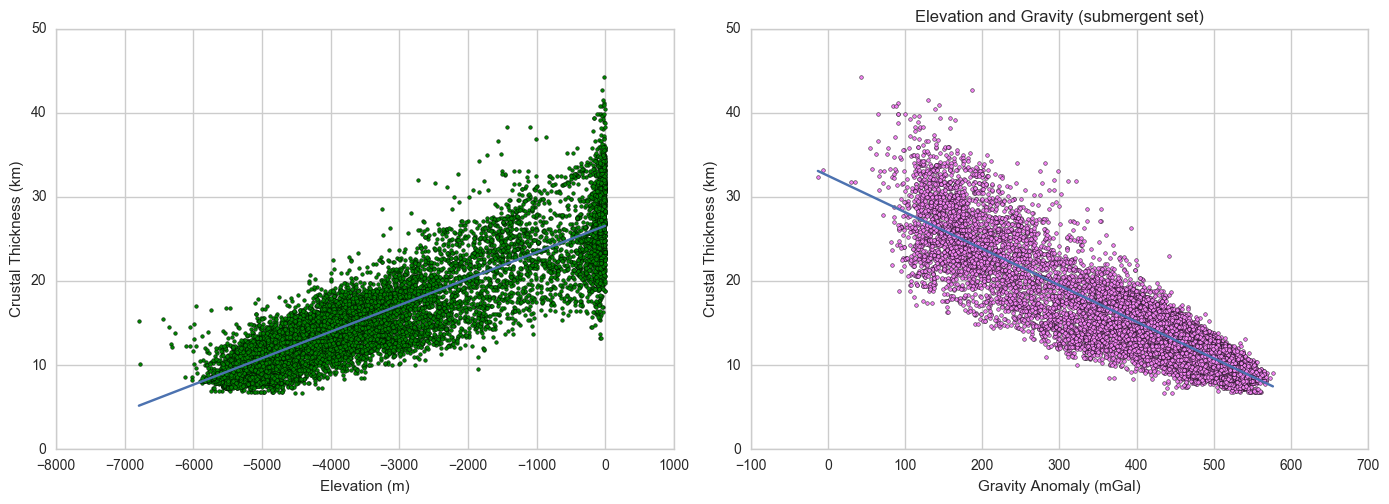

In [17]:
### submergent

fig2 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax2 = fig2.add_subplot(1,2,1)
    ax2.scatter(df_wet.Elevation, df_wet.CrustThk, s=7, c='green', label='')
    ax2.set_xlabel('Elevation (m)')
    ax2.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax2.plot(np.unique(df_wet.Elevation), np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))(np.unique(df_wet.Elevation)))
    
    ax2 = fig2.add_subplot(1,2,2)
    ax2.scatter(df_wet.Gravity, df_wet.CrustThk, s=7, c='violet', label='')
    ax2.set_xlabel('Gravity Anomaly (mGal)')
    ax2.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax2.plot(np.unique(df_wet.Gravity), np.poly1d(np.polyfit(df_wet.Gravity, df_wet.CrustThk, 1))(np.unique(df_wet.Gravity)))
    
    plt.tight_layout()
    plt.title('Elevation and Gravity (submergent set)')
    plt.show()

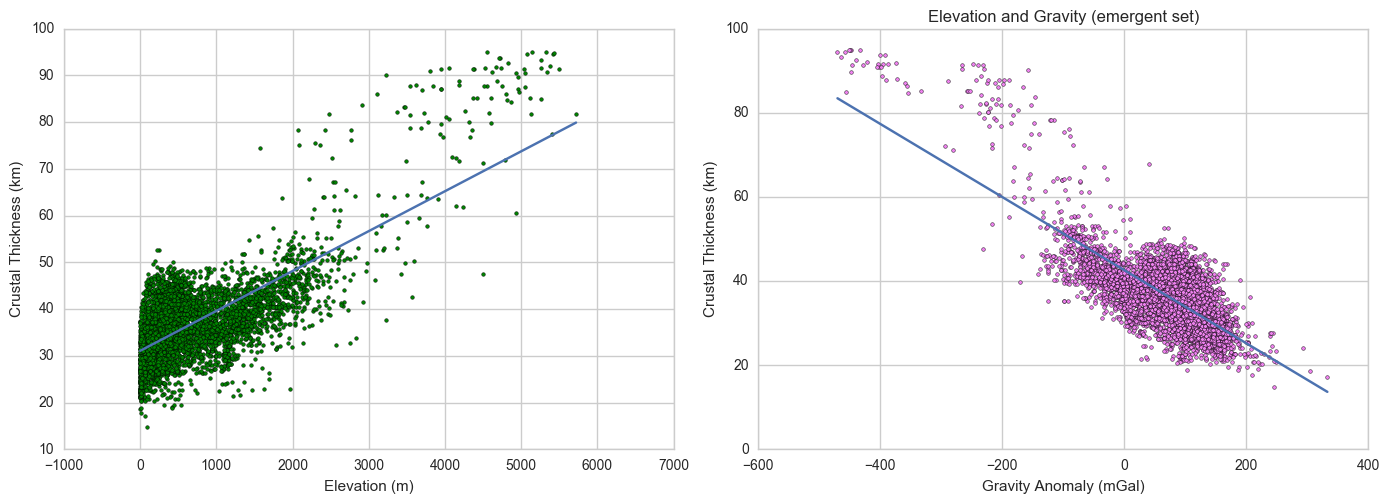

In [18]:
### emergent

fig3 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax3 = fig3.add_subplot(1,2,1)
    ax3.scatter(df_dry.Elevation, df_dry.CrustThk, s=7, c='green', label='')
    ax3.set_xlabel('Elevation (m)')
    ax3.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax3.plot(np.unique(df_dry.Elevation), np.poly1d(np.polyfit(df_dry.Elevation, df_dry.CrustThk, 1))(np.unique(df_dry.Elevation)))
    
    ax3 = fig3.add_subplot(1,2,2)
    ax3.scatter(df_dry.Gravity, df_dry.CrustThk, s=7, c='violet', label='')
    ax3.set_xlabel('Gravity Anomaly (mGal)')
    ax3.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax3.plot(np.unique(df_dry.Gravity), np.poly1d(np.polyfit(df_dry.Gravity, df_dry.CrustThk, 1))(np.unique(df_dry.Gravity)))
    
    plt.tight_layout()
    plt.title('Elevation and Gravity (emergent set)')
    plt.show()

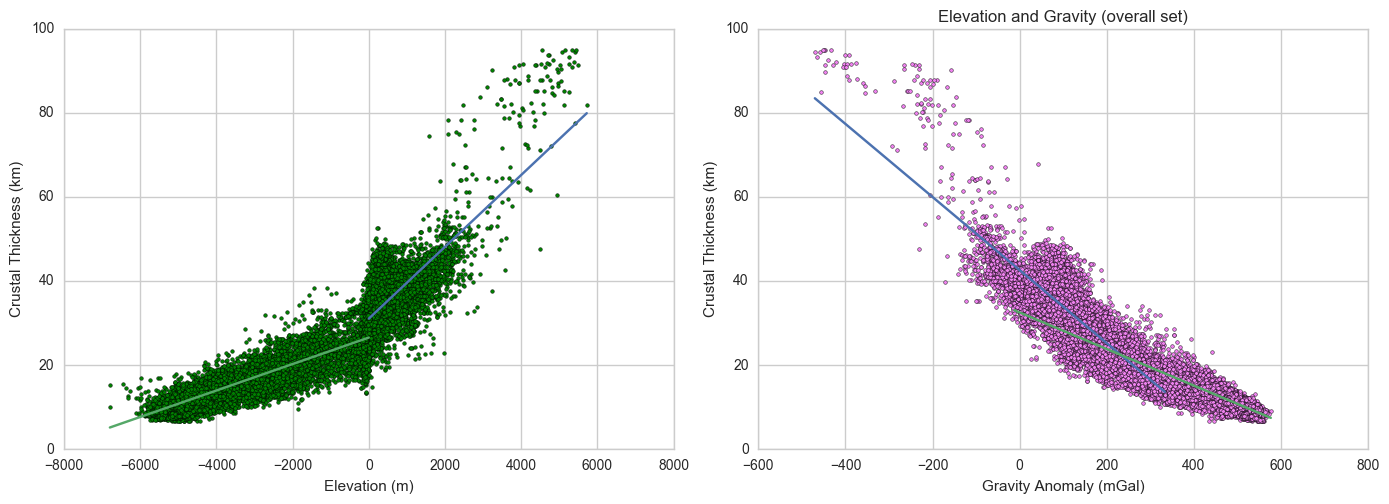

In [21]:
### overall data with regression model polyfits:

fig4 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax4 = fig4.add_subplot(1,2,1)
    ax4.scatter(df.Elevation, df.CrustThk, s=7, c='green', label='')
    ax4.set_xlabel('Elevation (m)')
    ax4.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax4.plot(np.unique(df_dry.Elevation), np.poly1d(np.polyfit(df_dry.Elevation, df_dry.CrustThk, 1))(np.unique(df_dry.Elevation)))
    ax4.plot(np.unique(df_wet.Elevation), np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))(np.unique(df_wet.Elevation)))


        
    ax4 = fig4.add_subplot(1,2,2)
    ax4.scatter(df.Gravity, df.CrustThk, s=7, c='violet', label='')
    ax4.set_xlabel('Gravity Anomaly (mGal)')
    ax4.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax4.plot(np.unique(df_dry.Gravity), np.poly1d(np.polyfit(df_dry.Gravity, df_dry.CrustThk, 1))(np.unique(df_dry.Gravity)))
    ax4.plot(np.unique(df_wet.Gravity), np.poly1d(np.polyfit(df_wet.Gravity, df_wet.CrustThk, 1))(np.unique(df_wet.Gravity)))


    plt.tight_layout()
    plt.title('Elevation and Gravity (overall set)')
    plt.show()

__Q: Looking at the intersections of the model lines in each plot, what is the thickness of crust where they intersect?__

Here, we consider the possibility that this intersection point is in some meaningful way, indicative of the position of the OCT, or a good fit first estimate of the OCT. From here, if it is indeed so, we can refine using cluster and correlation analyses for further refinement, before moving on to worldwide sampling, then trying to train a ML model to "pluck" from the depths a good OCT for mapping purposes...or something like that.

In [28]:
# dy_ : model slope;  dx0_ : y-intersect

# for elevation:
dy_dry, dx0_dry = np.poly1d(np.polyfit(df_dry.Elevation, df_dry.CrustThk, 1))
dy_wet, dx0_wet = np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))

# for gravity:
p_gdry = np.poly1d(np.polyfit(df_dry.Gravity, df_dry.CrustThk, 1))
p_gwet = np.poly1d(np.polyfit(df_wet.Gravity, df_wet.CrustThk, 1))

p_gwet

poly1d([ -0.04344687,  32.53279274])

In [6]:
data_array=df.ix[:,1]
num_classes=2
gvf_threshold=0.8

breaks=ComputeClusterBndys(data_array, num_classes, gvf_threshold)

print('Done')
print()
print('Natural Breaks Optimization Result:')
print(breaks)

Trying 2 class breaks...
Trying 3 class breaks...
Trying 4 class breaks...
Done

Natural Breaks Optimization Result:
[array([ 13.602264,  21.957979,  34.332996,  94.968056])]


In [30]:


# now, rerun the N-B optimization, this time using only the submerged records:
pc_array = np.array(df_wet.ix[:,1])    # extract the crustal thickness column from the df
breaksList=[]

klasses=2
gvf = 0.0
gvf_acceptance=0.80
    
# compute F-J natural breaks and goodness of fit:
while(gvf < gvf_acceptance):
    print('Trying', klasses, 'class breaks...')
    # classify data using PySAL Natural Breaks Lib.
    breaks=ComputeNaturalBreaks(pc_array, klasses)

    # compute goodness of variance fit
    gvf = goodness_of_variance_fit(pc_array, breaks.bins)   #(data, nclasses)
    klasses+=1
    
breaksList.append(breaks.bins)  

print('Natural Breaks Optimization Result:')
print(breaksList)

Trying 2 class breaks...
Trying 3 class breaks...
Trying 4 class breaks...
Natural Breaks Optimization Result:
[array([ 11.403069,  15.555084,  22.370525,  44.235935])]


Interesting. Let's plot them submerged data and see if a more distinct pattern emerges:

First, we'll look at both the submergent and emergent data:

Now, we look only at relationships below sea level:

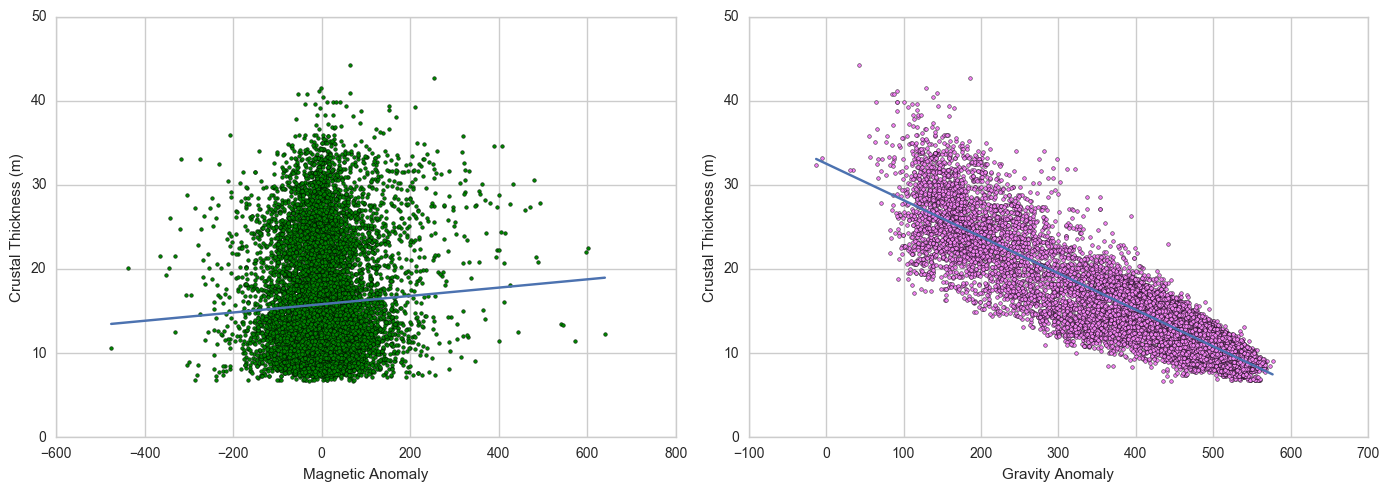

In [53]:
fig3 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax3 = fig3.add_subplot(1,2,1)
    ax3.scatter(df_wet.Magnetic, df_wet.CrustThk, s=7, c='green', label='')
    ax3.set_xlabel('Magnetic Anomaly')
    ax3.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax3.plot(np.unique(df_wet.Magnetic), np.poly1d(np.polyfit(df_wet.Magnetic, df_wet.CrustThk, 1))(np.unique(df_wet.Magnetic)))
    
    ax3 = fig3.add_subplot(1,2,2)
    ax3.scatter(df_wet.Gravity, df_wet.CrustThk, s=7, c='violet', label='')
    ax3.set_xlabel('Gravity Anomaly')
    ax3.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax3.plot(np.unique(df_wet.Gravity), np.poly1d(np.polyfit(df_wet.Gravity, df_wet.CrustThk, 1))(np.unique(df_wet.Gravity)))
    
    plt.tight_layout()
    plt.show()

Interesting...



__ Next Q: How does crustal thickness vary, if at all, with elevation?__

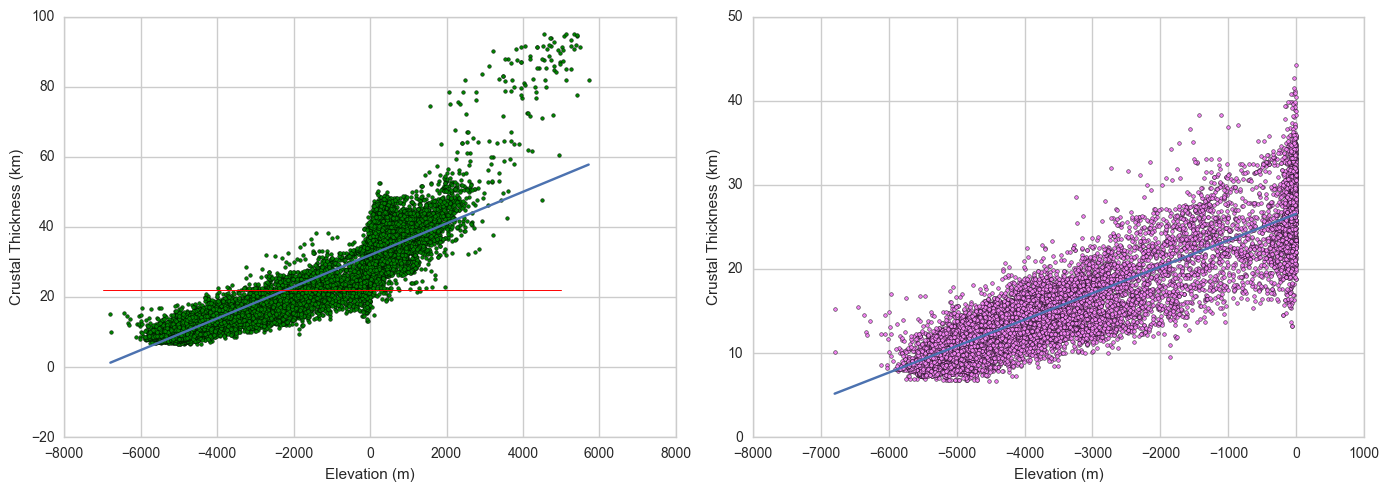

In [60]:
fig4 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax4 = fig4.add_subplot(1,2,1)
    ax4.scatter(df.Elevation, df.CrustThk, s=7, c='green', label='')
    ax4.set_xlabel('Elevation (m)')
    ax4.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax4.plot(np.unique(df.Elevation), np.poly1d(np.polyfit(df.Elevation, df.CrustThk, 1))(np.unique(df.Elevation)))
    
    # added post-plot
    ax4.plot( (-7000,5000),(22,22), lw=0.7, c='r', label='22 km thickness partition' )
    
    
    ax4 = fig4.add_subplot(1,2,2)
    ax4.scatter(df_wet.Elevation, df_wet.CrustThk, s=7, c='violet', label='')
    ax4.set_xlabel('Elevation (m)')
    ax4.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax4.plot(np.unique(df_wet.Elevation), np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))(np.unique(df_wet.Elevation)))
    
    plt.tight_layout()
    plt.show()

Depth (or height) and crustal thickness (overall) appear to share a curvilinear relationship--one that can be linearized by examining the submergent and emergent sections individually. Doing so, shows reasonably good linear relations. Further, one could also see a second linear-ish trend in those thicknesses greater than 35 to 40 km.  

Further, if we overprint some earlier results that attempted to partition, or cluster, crustal thickness from NOAA using Natural Breaks:

Natural Breaks Optimization Result:
[array([ 11.403069,  15.555084,  22.370525,  44.235935])]

...adding the 22.37 km partition (red line) to the overall elevation vs thickness plot (on the left)...

Continued on notebook: *CMM Sample Data (20k pnts) Crustal Thickness Analysis II*